In [35]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
print(os.getcwd())

c:\Users\jakob\Desktop\Fertige Notebooks


Load each csv file and combine them to one

In [36]:
# Load master data
aoe_data = pd.read_csv('C:/Users/jakob/Desktop/Code Seminar Strategy Mining/aoe_data.csv')

df_list = []
file_num = 0
directory_path = 'C:/Users/jakob/Downloads/archive/inputs/inputs'
file_count = 0

for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_count += 1
        if file_count <= 5000:
            filepath = os.path.join(directory_path, filename)
            df = pd.read_csv(filepath)
            file_numbers = re.findall(r'\d+', filename) 
            if file_numbers:
                df['file_name'] = int(file_numbers[0])
            else:
                df['file_name'] = None
            df['file_num'] = file_num
            file_num += 2
            df_list.append(df)
        else:
            break

big_combined_df = pd.concat(df_list)

Copy the elo and duration from the master scv file

In [37]:
elo_mapping = aoe_data.set_index('match_id')['elo'].to_dict()
duration_mapping = aoe_data.set_index('match_id')['duration'].to_dict()

big_combined_df['elo'] = big_combined_df['file_name'].map(elo_mapping)
big_combined_df['duration'] = big_combined_df['file_name'].map(duration_mapping)



Calculate APM from actions and duration of the game

In [38]:
big_combined_df['row_count'] = big_combined_df.groupby('file_num')['file_num'].transform('count')
big_combined_df['apm'] = big_combined_df['row_count'] / (big_combined_df['duration'] / 60)


Create column Match_ID and transform 'file_num' to give each player an ID

In [39]:
big_combined_df.loc[big_combined_df['player'] == 'p2', 'file_num'] +=1
big_combined_df['Match_ID'] = (big_combined_df['file_num'] // 2) + 1

Drop all matches which do not have Resign/winner in data

In [40]:
resigned = big_combined_df.loc[big_combined_df['type'] == 'Resign']

all_matches = list(range(1000))
good_matches = resigned['Match_ID'].unique().tolist()

missing_matches = list(set(all_matches) - set(good_matches))
big_combined_df = big_combined_df[~big_combined_df['Match_ID'].isin(missing_matches)]
print(missing_matches)


[0, 325, 486, 870, 934, 521, 817, 699, 671]


In [41]:
mean_time = big_combined_df
mean_time_grouped =  mean_time.groupby('Match_ID')
df = mean_time_grouped.last()

Create boxplotes to get a better understanding of the data

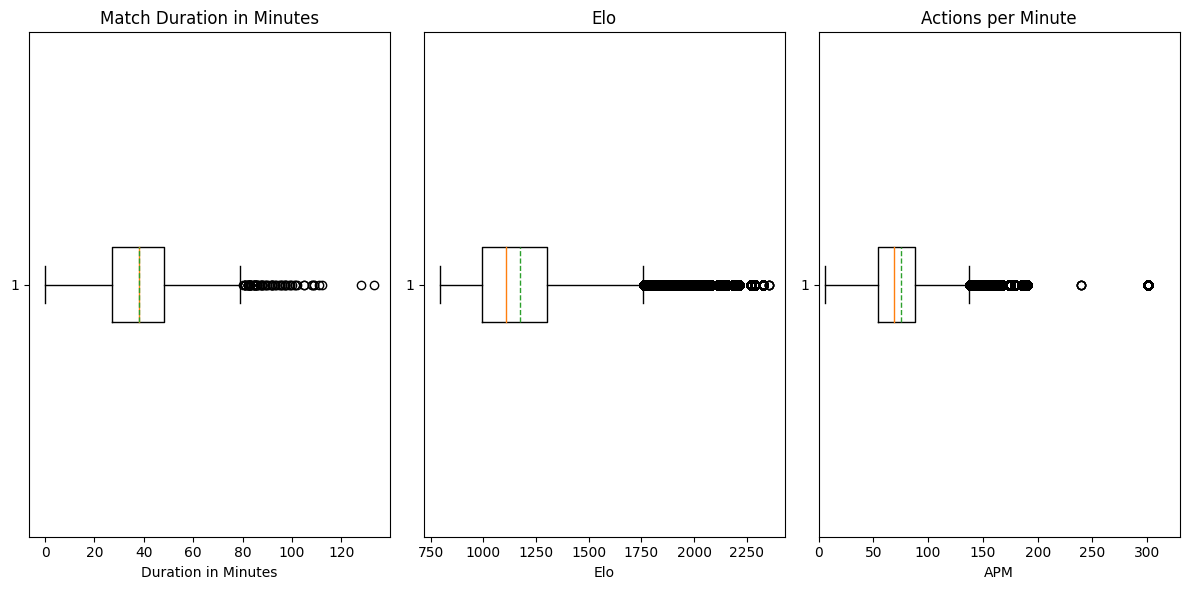

count    4992.000000
mean       38.074519
std        16.958033
min         0.000000
25%        27.000000
50%        38.000000
75%        48.000000
max       133.000000
Name: minutes, dtype: float64
count    1.253162e+07
mean     1.172815e+03
std      2.520572e+02
min      7.940000e+02
25%      9.920000e+02
50%      1.105000e+03
75%      1.300000e+03
max      2.354000e+03
Name: elo, dtype: float64
count    1.253162e+07
mean     7.498981e+01
std      1.475940e+02
min      6.226415e+00
25%      5.427136e+01
50%      6.922342e+01
75%      8.760684e+01
max      1.135636e+04
Name: apm, dtype: float64


In [42]:
df['minutes'] = pd.to_datetime(df['timestamp']).dt.hour * 60 + pd.to_datetime(df['timestamp']).dt.minute

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Minutes Boxplot 
axes[0].boxplot(df['minutes'], vert=False, showmeans=True, meanline=True)
axes[0].set_xlabel('Duration in Minutes')
axes[0].set_title('Match Duration in Minutes')

# Elo Boxplot
axes[1].boxplot(big_combined_df['elo'], vert=False, showmeans=True, meanline=True)
axes[1].set_xlabel('Elo')
axes[1].set_title('Elo')

# APM Boxplot
axes[2].boxplot(big_combined_df['apm'], vert=False, showmeans=True, meanline=True)
axes[2].set_xlabel('APM')
axes[2].set_xlim(0, 330)
axes[2].set_title('Actions per Minute')

plt.tight_layout()

plt.show()

statistics_time = df['minutes'].describe()
print(statistics_time)
statistics_elo = big_combined_df['elo'].describe()
print(statistics_elo)
statistics_apm = big_combined_df['apm'].describe()
print(statistics_apm)

Create a Winner column which says 1 for winner and 0 for looser

In [43]:
resigned['Winner'] = 0

looser_list = resigned['file_num'].tolist()
len(looser_list)

big_combined_df['Winner'] = big_combined_df['file_num'].isin(looser_list).astype(int)



Time Filter: Uncomment the line with the preferred filter or leave all as comments to use the data throughout the game

In [44]:
#big_combined_df = big_combined_df[big_combined_df['timestamp'].apply(lambda x: pd.to_timedelta(x) <= pd.Timedelta(minutes=10))]
big_combined_df = big_combined_df[big_combined_df['timestamp'].apply(lambda x: pd.to_timedelta(x) <= pd.Timedelta(minutes=20))]
#big_combined_df = big_combined_df[big_combined_df['timestamp'].apply(lambda x: pd.to_timedelta(x) <= pd.Timedelta(minutes=30))]
#big_combined_df = big_combined_df[big_combined_df['timestamp'].apply(lambda x: pd.to_timedelta(x) <= pd.Timedelta(minutes=40))]


Filter for Unit creation

In [45]:
unit_prep_df = big_combined_df[['timestamp','type', 'param','player', 'file_num', 'Match_ID', 'Winner']]
unit_prep_df = unit_prep_df[(unit_prep_df['type'] == 'Queue')]

unit_final_df = unit_prep_df[['timestamp', 'param', 'file_num', 'type', 'Match_ID', 'Winner']]
unit_final_df = unit_final_df.rename(columns={'param': 'unit'})
unit_final_df_sorted = unit_final_df.reset_index(drop=True)

Aggregate timestamps for each player, Unit

In [46]:
unit_grouped = unit_final_df_sorted.groupby(['file_num', 'unit']).agg({'timestamp': list, 'Match_ID': 'first', 'Winner': 'first'})
unit_new_df = pd.DataFrame(unit_grouped).reset_index()

Identify players with missing UNIT data (less data) and create LIST

In [47]:
all_players = list(range(2000))

existing_players = unit_new_df['file_num'].unique().tolist()

unit_missing_players = list(set(all_players) - set(existing_players))

print(unit_missing_players)
print(len(unit_missing_players))

[648, 649, 268, 269, 1550, 1656, 1040, 1041, 1935, 934, 1972, 1340, 1341, 1852, 321, 458, 970, 971, 1738, 1739, 1866, 1867, 480, 1632, 1633, 232, 233, 1128, 748, 749, 1396, 1397, 1653, 1909, 1016]
35


Same procedure for Tech

In [48]:
tech_prep_df = big_combined_df[['timestamp','type', 'param','player', 'file_num', 'Match_ID', 'Winner']]
tech_prep_df = tech_prep_df[(tech_prep_df['type'] == 'Research')]

tech_final_df = tech_prep_df[['timestamp', 'param', 'file_num', 'type', 'Match_ID', 'Winner']]
tech_final_df = tech_final_df.rename(columns={'param': 'tech'})
tech_final_df_sorted = tech_final_df.reset_index(drop=True)
tech_final_df_sorted

,timestamp,tech,file_num,type,Match_ID,Winner
0,0:07:23.947000,Loom,0,Research,1,1
1,0:08:03.082000,Feudal Age,0,Research,1,1
2,0:10:47.707000,Feudal Age,1,Research,1,0
3,0:10:51.487000,Loom,1,Research,1,0
4,0:10:51.907000,Feudal Age,1,Research,1,0
...,...,...,...,...,...,...
61597,0:13:31.579000,Man-at-Arms,9999,Research,5000,0
61598,0:15:44.573000,Horse Collar,9998,Research,5000,1
61599,0:16:33.247000,Wheelbarrow,9998,Research,5000,1
61600,0:16:33.863000,Loom,9998,Research,5000,1


In [49]:
tech_grouped = tech_final_df_sorted.groupby(['file_num', 'tech']).agg({'timestamp': list, 'Match_ID': 'first', 'Winner': 'first'})
tech_new_df = pd.DataFrame(tech_grouped).reset_index()

In [50]:
all_players = list(range(2000))

existing_players = tech_new_df['file_num'].unique().tolist()

tech_missing_players = list(set(all_players) - set(existing_players))

print(tech_missing_players)
print(len(tech_missing_players))

[1550, 1551, 1040, 1041, 18, 19, 1059, 1061, 64, 65, 72, 73, 589, 1113, 1632, 1633, 1128, 1644, 1653, 1656, 1657, 648, 649, 652, 653, 658, 659, 1184, 1185, 1738, 1739, 1230, 1231, 1254, 1255, 232, 233, 748, 749, 249, 762, 763, 1788, 1285, 268, 269, 1334, 314, 315, 1340, 1341, 1852, 320, 321, 1866, 1867, 1870, 1871, 878, 1396, 1397, 1908, 1909, 1914, 382, 1934, 1935, 914, 915, 404, 405, 934, 434, 435, 1972, 458, 459, 970, 971, 464, 465, 1500, 1501, 480, 481, 1522, 1523, 1016, 1017, 510, 511]
91


Same procedure for buildings

In [51]:
build_prep_df = big_combined_df[['timestamp','type', 'param','player', 'file_num', 'Match_ID', 'Winner']]
build_prep_df = build_prep_df[(build_prep_df['type'] == 'Build')]

build_final_df = build_prep_df[['timestamp', 'param', 'file_num', 'type', 'Match_ID', 'Winner']]
build_final_df = build_final_df.rename(columns={'param': 'building'})
build_final_df_sorted = build_final_df.reset_index(drop=True)

Aggregate timestamps for each player building

In [52]:
build_grouped = build_final_df_sorted.groupby(['file_num', 'building']).agg({'timestamp': list, 'Match_ID': 'first', 'Winner': 'first'})
build_new_df = pd.DataFrame(build_grouped).reset_index()

In [53]:
all_players = list(range(2000))

existing_players = build_new_df['file_num'].unique().tolist()

build_missing_players = list(set(all_players) - set(existing_players))

print(build_missing_players)
print(len(build_missing_players))

[648, 649, 268, 269, 1550, 1935, 1040, 1041, 404, 934, 1972, 1340, 1341, 1852, 321, 458, 970, 971, 1738, 1739, 1866, 1867, 480, 1632, 1633, 232, 233, 1128, 749, 1396, 1397, 1653, 1656]
33


Drop rows from build of player that are dropped in units and tech and other way around to have consistent amount of rows for later merge

In [54]:
build_new_df = build_new_df[~build_new_df['file_num'].isin(unit_missing_players)]
build_new_df = build_new_df[~build_new_df['file_num'].isin(tech_missing_players)]

In [55]:
build_df_timestamps = build_new_df.pivot(index='file_num', columns='building', values='timestamp').reset_index()
build_df_timestamps = build_df_timestamps.merge(build_new_df[['file_num', 'Match_ID', 'Winner']].drop_duplicates(), on='file_num')


Drop players in units with missung players from build and tech

In [56]:
unit_new_df = unit_new_df[~unit_new_df['file_num'].isin(build_missing_players)]
unit_new_df = unit_new_df[~unit_new_df['file_num'].isin(tech_missing_players)]

In [57]:
unit_df_timestamps = unit_new_df.pivot(index='file_num', columns='unit', values='timestamp').reset_index()
unit_df_timestamps = unit_df_timestamps.merge(unit_new_df[['file_num', 'Match_ID', 'Winner']].drop_duplicates(), on='file_num')

Drop players in tech with missing players from unit and build

In [58]:
tech_new_df = tech_new_df[~tech_new_df['file_num'].isin(build_missing_players)]
tech_new_df = tech_new_df[~tech_new_df['file_num'].isin(unit_missing_players)]

In [59]:
tech_df_timestamps = tech_new_df.pivot(index='file_num', columns='tech', values='timestamp').reset_index()
tech_df_timestamps = tech_df_timestamps.merge(tech_new_df[['file_num', 'Match_ID', 'Winner']].drop_duplicates(), on='file_num')

Convert dataframe to count length list

In [60]:
# Function to transform values
def transform_value(value):
    if isinstance(value, list):
        return len(value)
    elif pd.notna(value):
        return value
    else:
        return 0

unit_df = unit_df_timestamps.applymap(transform_value)
building_df = build_df_timestamps.applymap(transform_value)
tech_df = tech_df_timestamps.applymap(transform_value)

In [61]:
dropped_unit_df = unit_df.copy()
dropped_tech_df = tech_df.copy()

# drop columns'Winner', Match_ID', 'file_num'
dropped_unit_df.drop(columns=['Winner', 'Match_ID', 'file_num'], inplace=True)
dropped_tech_df.drop(columns=['Winner', 'Match_ID', 'file_num'], inplace=True)

building_and_unit_and_tech_df = pd.concat([building_df, dropped_unit_df, dropped_tech_df], axis=1)
building_and_unit_and_tech_df.reset_index(drop=True, inplace=True)

Aggregate Columns to military Buildings, economic, defensive, etc.

In [62]:
aggregated_building_df = building_df.copy()

economic_building = ['Farm', 'Town Center', 'Mill', 'Market', 'Lumber Camp', 'Mining Camp', 'Dock', 'Fish Trap', 'Feitoria']
research_building = ['Blacksmith', 'University']
defensive_building = ['Outpost', 'Palisade Gate', 'Gate', 'Watch Tower', 'Bombard Tower', 'Castle']
military_production = ['Baracks', 'Archery Range', 'Stable', 'Siege Workshop', 'Harbor', 'Krepost', 'Castle', 'Monastery']
other_building = ['House', 'Wonder']


filtered_economic_building = [building for building in economic_building if building in building_df.columns]
filtered_research_building = [building for building in research_building if building in building_df.columns]
filtered_defensive_building = [building for building in defensive_building if building in building_df.columns]
filtered_military_building = [building for building in military_production if building in building_df.columns]
filtered_other_building = [building for building in other_building if building in building_df.columns]

aggregated_building_df['Economic Building'] = aggregated_building_df[filtered_economic_building].sum(axis=1)
aggregated_building_df['Research Building'] = aggregated_building_df[filtered_research_building].sum(axis=1)
aggregated_building_df['Defensive Building'] = aggregated_building_df[filtered_defensive_building].sum(axis=1)
aggregated_building_df['Military Building'] = aggregated_building_df[filtered_military_building].sum(axis=1)
aggregated_building_df['Other Building'] = aggregated_building_df[filtered_other_building].sum(axis=1)

aggregated_building_df.drop(columns=filtered_economic_building + filtered_research_building + filtered_defensive_building + filtered_military_building + filtered_other_building, inplace=True)

aggregated_building_df = aggregated_building_df[['file_num', 'Match_ID', 'Winner', 'Economic Building', 'Research Building', 'Defensive Building', 'Military Building', 'Other Building']]


Aggregate Units to Melee, Range, Cavalry, Siege and other

In [63]:
aggregated_unit_df = unit_df.copy()

ranged_units = ['Archer', 'Arambai', 'Ballista Elephant', 'Camel Archer', 'Cavalry Archer', 'Chu Ko Nu', 'Conquistador', 'Genoese Crossbowman', 'Hand Cannoneer', 'Janissary', 'Kipchak', 'Longbowman', 'Mangudai', 'Plumed Archer', 'Rattan Archer', 'Skirmisher', 'Slinger']
melee_units = ['Berserk', 'Eagle Scout', 'Gbeto', 'Huskarl', 'Jaguar Warrior', 'Kamayuk', 'Militia', 'Samurai', 'Shotel Warrior', 'Spearman', 'Teutonic Knight', 'Throwing Axeman', 'Woad Raider']
cavalry_units = ['Arambai', 'Battle Elephant', 'Boyar', 'Camel Archer', 'Camel Rider', 'Cavalry Archer', 'Conquistador', 'Keshik', 'Kipchak', 'Knight', 'Konnik', 'Leitis', 'Missionary','Scout Cavalry', 'Steppe Lancer', 'Tarkan', 'War Elephant']
siege_units = ['Ballista Elephant', 'Battering Ram', 'Bombard Cannon', 'Mangonel', 'Organ Gun', 'Petard','Scorpion', 'Siege Tower', 'Trebuchet']
other_units = ['Demolition Raft', 'Fire Galley', 'Fishing Ship', 'Galley', 'Monk', 'None', 'Trade Cart', 'Transport Ship', 'Villager', 'War Wagon']


filtered_ranged_units = [unit for unit in ranged_units if unit in unit_df.columns]
filtered_melee_units = [unit for unit in melee_units if unit in unit_df.columns]
filtered_cavalry_units = [unit for unit in cavalry_units if unit in unit_df.columns]
filtered_siege_units = [unit for unit in siege_units if unit in unit_df.columns]
filtered_other_units = [unit for unit in other_units if unit in unit_df.columns]

aggregated_unit_df['Ranged Units'] = aggregated_unit_df[filtered_ranged_units].sum(axis=1)
aggregated_unit_df['Melee Units'] = aggregated_unit_df[filtered_melee_units].sum(axis=1)
aggregated_unit_df['Cavalry Units'] = aggregated_unit_df[filtered_cavalry_units].sum(axis=1)
aggregated_unit_df['Siege Units'] = aggregated_unit_df[filtered_siege_units].sum(axis=1)
aggregated_unit_df['Other Units'] = aggregated_unit_df[filtered_other_units].sum(axis=1)

aggregated_unit_df.drop(columns=filtered_ranged_units + filtered_melee_units + filtered_cavalry_units + filtered_siege_units + filtered_other_units, inplace=True)

aggregated_unit_df = aggregated_unit_df[['file_num', 'Match_ID', 'Winner', 'Ranged Units', 'Melee Units', 'Cavalry Units', 'Siege Units', 'Other Units']]


Aggregate tech to Building, Economy, Monastery, Infantry, Missile/Siege, Cavalry, Dock, Other, Age

In [64]:
aggregated_tech_df = tech_df.copy()

building_tech = ['Town Watch', 'Town Patrol', 'Treadmill Crane', 'Masonry', 'Architecture', 'Hoardings', 'Conscription']
economy_tech = ['Wheelbarrow', 'Hand Cart', 'Double-Bit Axe', 'Bow Saw', 'Two-Man Saw', 'Gold Mining', 'Gold Shaft Mining', 'Stone Mining', 'Stone Shaft Mining', 'Crop Rotation', 'Heavy Plow', 'Horse Collar', 'Coinage', 'Banking', 'Guilds', 'Caravan', 'Gillnets']
monastery_tech = ['Redemption', 'Atonement', 'Herbal Medicine', 'Heresy', 'Sanctity', 'Fervor', 'Faith', 'Illumination', 'Block Printing', 'Theocracy']
infantery_tech = ['Supplies', 'Squires', 'Arson', 'Forging', 'Iron Casting', 'Blast Furnace', 'Scale Mail Armor', 'Chain Mail Armor', 'Plate Mail Armor', 'Bodkin Arrow', 'Fletching', 'Bracer', 'Padded Archer Armor', 'Leather Archer Armor', 'Ring Archer Armor', 'Squires', 'Arson', 'Forging', 'Iron Casting', 'Blast Furnace', 'Scale Mail Armor', 'Chain Mail Armor', 'Plate Mail Armor']
missile_siege_tech = ['Thumb Ring', 'Parthian Tactics', 'Fletching', 'Bodkin Arrow', 'Bracer', 'Padded Archer Armor', 'Leather Archer Armor', 'Ring Archer Armor', 'Siege Engineers', 'Ballistics', 'Chemistry', 'Heated Shot', 'Chemistry', 'Murder Holes', 'Arrowslits']
cavalry_tech = ['Bloodlines', 'Husbandry', 'Forging', 'Iron Casting', 'Blast Furnace', 'Scale Barding Armor', 'Chain Barding Armor', 'Plate Barding Armor']
dock_tech = ['Careening', 'Dry Dock', 'Shipwright']
other_tech = ['Loom', 'Sappers']
age_tech = ['Feudal Age', 'Castle Age', 'Imperial Age']

filtered_building_tech = [tech for tech in building_tech if tech in tech_df.columns]
filtered_economy_tech = [tech for tech in economy_tech if tech in tech_df.columns]
filtered_monastery_tech = [tech for tech in monastery_tech if tech in tech_df.columns]
filtered_infantery_tech = [tech for tech in infantery_tech if tech in tech_df.columns]
filtered_missile_siege_tech = [tech for tech in missile_siege_tech if tech in tech_df.columns]
filtered_cavalry_tech = [tech for tech in cavalry_tech if tech in tech_df.columns]
filtered_dock_tech = [tech for tech in dock_tech if tech in tech_df.columns]
filtered_other_tech = [tech for tech in other_tech if tech in tech_df.columns]
filtered_age_tech = [tech for tech in age_tech if tech in tech_df.columns]


aggregated_tech_df['Building Tech'] = aggregated_tech_df[filtered_building_tech].sum(axis=1)
aggregated_tech_df['Economy Tech'] = aggregated_tech_df[filtered_economy_tech].sum(axis=1)
aggregated_tech_df['Monastery Tech'] = aggregated_tech_df[filtered_monastery_tech].sum(axis=1)
aggregated_tech_df['Infantery Tech'] = aggregated_tech_df[filtered_infantery_tech].sum(axis=1)
aggregated_tech_df['Missile-Siege Tech'] = aggregated_tech_df[filtered_missile_siege_tech].sum(axis=1)
aggregated_tech_df['Cavalry Tech'] = aggregated_tech_df[filtered_cavalry_tech].sum(axis=1)
aggregated_tech_df['Dock Tech'] = aggregated_tech_df[filtered_dock_tech].sum(axis=1)
aggregated_tech_df['Other Tech'] = aggregated_tech_df[filtered_other_tech].sum(axis=1)
aggregated_tech_df['Age Tech'] = aggregated_tech_df[filtered_age_tech].sum(axis=1)

aggregated_tech_df.drop(columns=filtered_building_tech + filtered_economy_tech + filtered_monastery_tech + filtered_infantery_tech + filtered_missile_siege_tech + filtered_cavalry_tech + filtered_dock_tech + filtered_other_tech + filtered_age_tech, inplace=True)

aggregated_tech_df = aggregated_tech_df[['file_num', 'Match_ID', 'Winner', 'Building Tech', 'Economy Tech', 'Monastery Tech', 'Infantery Tech', 'Missile-Siege Tech', 'Cavalry Tech', 'Dock Tech', 'Other Tech', 'Age Tech']]


Merge Unit, Building and Tech df together for cluster function

In [65]:
dropped_unit_df = aggregated_unit_df.copy()
dropped_tech_df = aggregated_tech_df.copy()

dropped_unit_df.drop(columns=['Winner', 'Match_ID', 'file_num'], inplace=True)
dropped_tech_df.drop(columns=['Winner', 'Match_ID', 'file_num'], inplace=True)

aggregated_building_unit_tech_df = pd.concat([aggregated_building_df, dropped_unit_df, dropped_tech_df], axis=1)
aggregated_building_unit_tech_df = aggregated_building_unit_tech_df.fillna(0)
building_and_unit_and_tech_df = building_and_unit_and_tech_df.fillna('None')

print(building_and_unit_and_tech_df[building_and_unit_and_tech_df.isnull().any(axis=1)])
# Reset the index of the merged dataframe
aggregated_building_unit_tech_df.reset_index(drop=True, inplace=True)


Empty DataFrame
Columns: [file_num, Archery Range, Barracks, Blacksmith, Castle, Dock, Donjon, Farm, Fish Trap, Gate, House, Krepost, Lumber Camp, Market, Mill, Mining Camp, Monastery, Outpost, Palisade Gate, Siege Workshop, Stable, Town Center, University, Watch Tower, Match_ID, Winner, Arambai, Archer, Battering Ram, Battle Elephant, Camel Rider, Cataphract, Cavalry Archer, Chu Ko Nu, Conquistador, Demolition Raft, Eagle Scout, Fire Galley, Fishing Ship, Galley, Genitour, Genoese Crossbowman, Hand Cannoneer, Huskarl, Janissary, Kamayuk, Karambit Warrior, Knight, Konnik, Leitis, Longboat, Longbowman, Mangonel, Mangudai, Militia, Monk, Organ Gun, Petard, Plumed Archer, Scorpion, Scout Cavalry, Serjeant, Shotel Warrior, Siege Tower, Skirmisher, Slinger, Spearman, Steppe Lancer, Throwing Axeman, Trade Cart, Trade Cog, Transport Ship, Turtle Ship, Villager, War Wagon, Woad Raider, Arson, Atonement, Bloodlines, Bodkin Arrow, Bow Saw, Careening, Castle Age, Cavalier, Chain Barding Armor, Ch

Save the dataframes to a csv file to load int the K-Means and DBSCAN notebook


In [66]:
aggregated_tech_df.to_csv('C:/Users/jakob/Desktop/Code Seminar Strategy Mining/dataframes/aggregated_tech_df.csv', index=False)
aggregated_unit_df.to_csv('C:/Users/jakob/Desktop/Code Seminar Strategy Mining/dataframes/aggregated_unit_df.csv', index=False)
aggregated_building_df.to_csv('C:/Users/jakob/Desktop/Code Seminar Strategy Mining/dataframes/aggregated_building_df.csv', index=False)
aggregated_building_unit_tech_df.to_csv('C:/Users/jakob/Desktop/Code Seminar Strategy Mining/dataframes/aggregated_building_unit_tech_df.csv', index=False)
building_and_unit_and_tech_df.to_csv('C:/Users/jakob/Desktop/Code Seminar Strategy Mining/dataframes/all_single_feature_build_unit_tech.csv', index=False)